# 04. News classification with LLM and RAG

Author: [ArtyomR](https://github.com/ArtyomR)  
Source: 

<span style="color:red">This Notebook was tested in Google Colab with GPU.</span>

**In this Notebook I'll walk through News classification with LLM and RAG**  
Next steps were implemented.
1. Download and intilalize Tokinizer and LLM
2. Create function for embedings
3. Create prompt
4. Create LLM answering function
5. Upload and prepare dataset
6. News classification
7. Prediction scorring

Dataset was creted within [Chinese AI news agregation project](https://t.me/chinese_ai_news).  

## Importing Necessary Libraries

In [2]:
!pip -q install peft transformers langchain sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 907.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 794.4/794.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from langchain.prompts import PromptTemplate
import tqdm

## Download and intialize models

In [3]:
%%time
adapt_model_name = "IlyaGusev/saiga_mistral_7b_lora"
base_model_name = "Open-Orca/Mistral-7B-OpenOrca"

device_map = {"": 0}

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.34 µs


In [4]:
model = AutoPeftModelForCausalLM.from_pretrained(
    adapt_model_name,
    device_map=device_map,
    torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_name,
    trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# Load model from HuggingFace Hub
sent_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
sent_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [7]:
def get_embedding(sentence):

    #Mean Pooling - Take attention mask into account for correct averaging
    def _mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # Tokenize sentences
    encoded_input = sent_tokenizer([sentence], padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = sent_model(**encoded_input)

    # Perform pooling
    sentence_embeddings = _mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    return sentence_embeddings

In [8]:
prompt_china_ai = PromptTemplate.from_template("user: {news_info}. Содержит ли этот текст информацию о китайском искуственном интеллекте?\nbot: Вот ответ на ваш вопрос длиной в одно слово (Да или Нет):")

In [9]:
def get_answer(info_prompt, news_info):

    prompt = info_prompt.format(news_info=news_info)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"),
                            top_p=0.5,
                            temperature=0.3,
                            attention_mask=inputs["attention_mask"],
                            max_new_tokens=100,
                            pad_token_id=tokenizer.eos_token_id,
                            do_sample=True)

    output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    parsed_answer = output.split("Вот ответ на ваш вопрос длиной в одно слово (Да или Нет):")[1].strip()

    if "bot:" in parsed_answer:
        parsed_answer = parsed_answer.split("bot:")[0].strip()

    # parsed_answer = output.split("bot:")[1].strip()
    return parsed_answer

### Test the model with one news.
Question in the prompt is "Содержит ли этот текст информацию о китайском искуственном интеллекте?"

In [10]:
news_info="Tencent Cloud запускает продукт для рисования с использованием искусственного интеллекта, поддерживающий более 25 созданных стилей 10 сентября IT House сообщила, что на конференции Tencent Global Digital Ecology Conference 2023, состоявшейся 7 сентября, компания Tencent Cloud официально представила новый продукт для рисования с использованием искусственного интеллекта, который использует собственную модель рисования с использованием искусственного интеллекта Tencent для обеспечения технологии создания и редактирования изображений с использованием искусственного интеллекта. позволяет пользователям легко создавать связанный с вводом графический контент на основе введенного текста или изображений. Согласно официальному сообщению, продукт для рисования с использованием искусственного интеллекта, выпущенный Tencent Cloud, на этот раз основан на модели алгоритма рисования, разработанной самостоятельно, и специально оптимизирован для возможностей создания рисунков в китайском контексте. Продукт включает в себя такие функции, как интеллектуальный Wenshengtu и интеллектуальный Wenshengtu, предоставляющий пользователям высокоточное создание изображений и преобразование стилей, которые поддерживают 25 различных стилей сцены, таких как китайский стиль, анимация, игры и традиционные картины."

Correct answer is Да (Yes).

In [11]:
%%time
answer = get_answer(prompt_china_ai, news_info)
print(f'Answer from model: {answer}')

Answer from model: Да.
CPU times: user 11.1 s, sys: 1.04 s, total: 12.2 s
Wall time: 13.6 s


### Upload test dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
test_data  = pd.read_excel('/content/drive/MyDrive/Data2/ai_articles_test_231124.xlsx',index_col=0)
test_data.head(2)

,published_flag,combined_text_ru,combined_text_ru_clean
1167,1,Tencent Cloud запускает продукт для рисования ...,tencent cloud запускать продукт для рисование ...
1542,1,Генеративный ИИ достиг «пика завышенных ожидан...,генеративный ия достигнуть пик завысить ожидан...


In [14]:
len(test_data)

926

### Split dataset for features (texts) and classes (labels)

In [15]:
texts = list(test_data['combined_text_ru'][:5])
labels = list(test_data['published_flag'][:5])

### Classification prediction

In [16]:
%%time
predictions = [get_answer(prompt_china_ai, t) for t in texts]

CPU times: user 48.8 s, sys: 4.02 s, total: 52.8 s
Wall time: 53.2 s


In [17]:
predictions[:5]

['Да.', 'Нет.', 'Нет.', 'Да.', 'Нет.']

In [18]:
texts = list(test_data['combined_text_ru'])
labels = list(test_data['published_flag'])

In [19]:
from tqdm import tqdm

In [20]:
%%time
# List to store the answers
predictions = []

# Using tqdm to create a progress bar
for t in tqdm(texts, desc="Processing texts", unit="text"):
    answer = get_answer(prompt_china_ai, t)
    predictions.append(answer)

Processing texts: 100%|██████████| 926/926 [2:29:53<00:00,  9.71s/text]

CPU times: user 2h 19min 31s, sys: 9min 12s, total: 2h 28min 44s
Wall time: 2h 29min 53s


In [21]:
len(predictions)

926

In [22]:
predictions[:10]

['Да.', 'Нет.', 'Нет.', 'Да.', 'Да.', 'Да.', 'Да.', 'Нет.', 'Да.', 'Да.']

In [23]:
dig_predictions = [1 if item == 'Да.' else 0 for item in predictions]
dig_predictions[:10]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1]

In [24]:
from sklearn.metrics import accuracy_score, classification_report

In [25]:
# Model accuracy
accuracy = accuracy_score(labels, dig_predictions)
print(f'Accuracy: {accuracy}')

# Additional metrics
print(classification_report(labels, dig_predictions))

Accuracy: 0.7192224622030238
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       525
           1       0.66      0.71      0.69       401

    accuracy                           0.72       926
   macro avg       0.72      0.72      0.72       926
weighted avg       0.72      0.72      0.72       926



In [26]:
from sklearn.metrics import f1_score

In [27]:
f1_score(labels, dig_predictions, average='macro')

0.7161719284181738

In [28]:
f1_score(labels, dig_predictions, average='micro')

0.7192224622030238

In [29]:
f1_score(labels, dig_predictions, average='weighted')

0.7201122012236051

## Confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix

In [32]:
# Generate confusion matrix for the predictions
conf_matrix = confusion_matrix(labels, dig_predictions)
conf_matrix

array([[381, 144],
       [116, 285]])

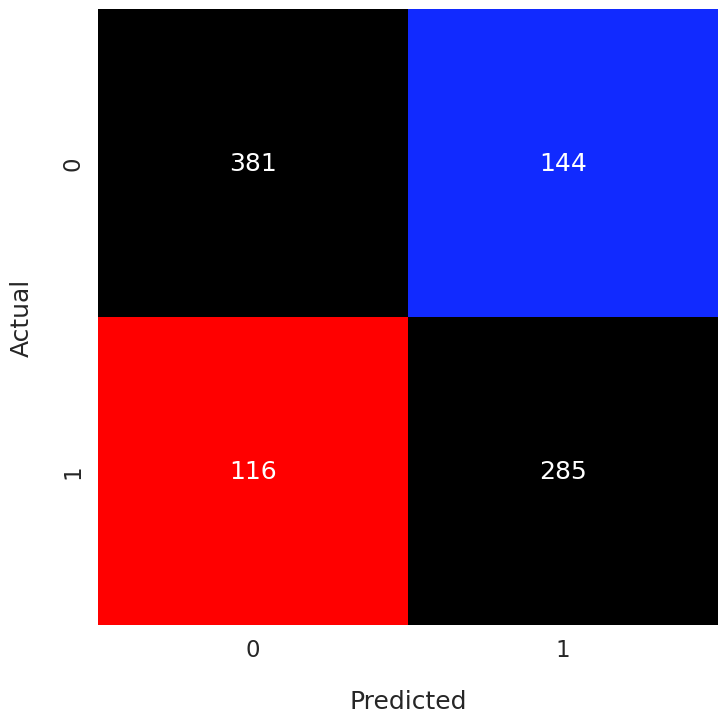

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

## Reference
- [Русский LLM-помощник (saiga) с кэшем, используя RAG (Retrieval-Augmented Generation)](https://habr.com/ru/articles/769124/)